### Phase 2 — Data Analytics and KPI Computation
Compensation Forecasting and Pay Equity Dashboard.

### Import Statements

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

import warnings
warnings.filterwarnings('ignore')

In [2]:
PROC_PATH = Path("../data/processed")
VISUAL_PATH = Path("../visualizations")
merged_df = pd.read_csv(PROC_PATH/"clean_employee_compensation.csv")
print("Data loaded successfully:", merged_df.shape)
merged_df.head()

Data loaded successfully: (385, 20)


,empid,department,position,salary,genderid,dateofhire,performancescore,gender,year,salaries,overtime,total_compensation,overtime_missing_flag,annual_salary_growth,overtime_ratio,department_avg_salary_gap,compensation_salary_ratio,gender_flag,tenure_years,tenure_bucket
0,10001,Production,Production Manager,72640,1,2016-01-28,Exceeds,Male,"2,015.00","174,788.60",94.67,"238,233.06",0,NaN,0.00,"12,682.02",3.28,1,9.70,5–10 yrs
1,10002,Production,Production Technician I,57568,0,2012-01-09,Exceeds,Female,"2,015.00","57,568.00",0.00,"57,568.00",1,NaN,0.00,"-2,389.98",1.00,0,13.80,10–20 yrs
2,10003,Production,Production Technician I,62910,0,2014-07-07,Exceeds,Female,"2,015.00","62,910.00",0.00,"62,910.00",1,NaN,0.00,"2,952.02",1.00,0,11.30,10–20 yrs
3,10004,Production,Production Technician I,47434,0,2011-11-07,Exceeds,Female,"2,015.00","47,434.00",0.00,"47,434.00",1,NaN,0.00,"-12,523.98",1.00,0,14.00,10–20 yrs
4,10005,Software Engineering,Software Engineer,108987,1,2011-11-07,Exceeds,Male,"2,015.00","92,192.96",0.00,"132,730.43",0,NaN,0.00,"13,540.73",1.22,1,14.00,10–20 yrs


### Gender Pay Equity Gap Index

In [3]:
# Overall Gender Pay Gap

overall_gap = (
    merged_df.groupby('gender')['salary']
    .mean()
    .reset_index()
    .pivot_table(values='salary', columns='gender')
)

overall_gap['pay_equity_gap_index'] = (
    overall_gap['Female'] / overall_gap['Male']
).round(2)

print("Overall Pay Equity Gap Index")
display(overall_gap)

Overall Pay Equity Gap Index


gender,Female,Male,pay_equity_gap_index
salary,"67,217.90","71,283.33",0.94


In [4]:
# Department-Level Gender Pay Gap

dept_gap = (
    merged_df.groupby(['department', 'gender'])['salary']
    .mean()
    .unstack()
    .reset_index()
)

dept_gap['pay_equity_gap_index'] = (
    dept_gap['Female'] / dept_gap['Male']
).round(2)

dept_gap = dept_gap.sort_values('pay_equity_gap_index')
print("Department-Level Gender Pay Gap:")
dept_gap.head()

Department-Level Gender Pay Gap:


gender,department,Female,Male,pay_equity_gap_index
0,Admin Offices,"66,944.75","73,523.00",0.91
2,IT/IS,"95,019.74","100,173.63",0.95
3,Production,"59,586.09","60,492.81",0.99
5,Software Engineering,"96,906.17","94,473.00",1.03
4,Sales,"69,482.47","66,827.05",1.04


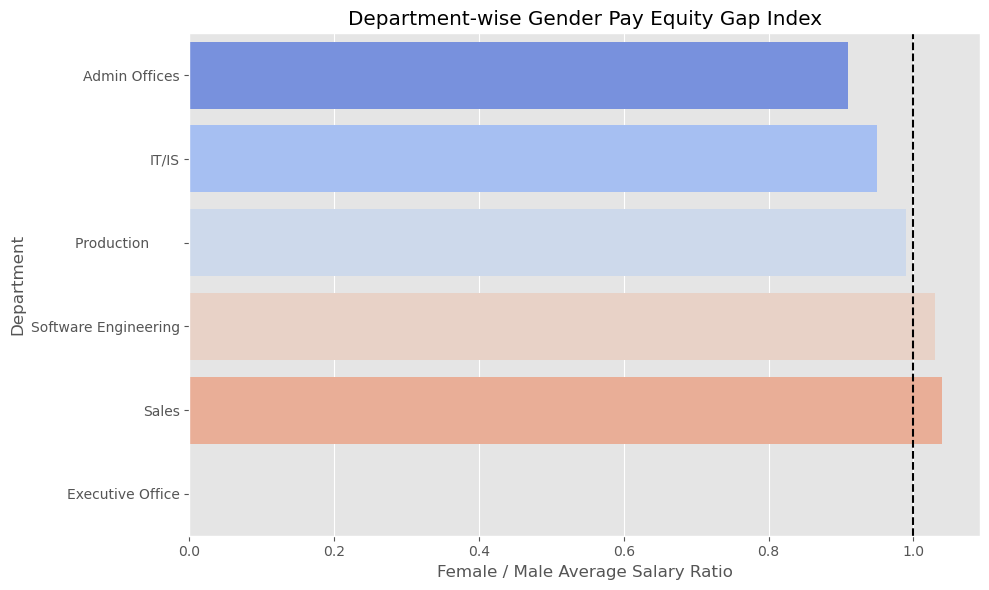

In [5]:
# Visualization for Department-wise Gender Pay Gap

plt.figure(figsize=(10,6))
sns.barplot(
    data=dept_gap,
    x='pay_equity_gap_index',
    y='department',
    palette='coolwarm'
)
plt.axvline(1, color='black', linestyle='--')
plt.title('Department-wise Gender Pay Equity Gap Index')
plt.xlabel('Female / Male Average Salary Ratio')
plt.ylabel('Department')
plt.tight_layout()
plt.savefig(VISUAL_PATH/'gender_pay_equity_gap.png', dpi=100)
plt.show()

### Interpretation

The bar chart compares average female and male salaries across departments.  
The vertical dashed line at 1.0 represents pay parity.  
Values below 1.0 indicate that females earn slightly less on average, while values above 1.0 show higher average female pay.

**Insights:**
- Admin Offices and IT/IS show minor pay gaps where females earn around 90–95% of male salaries.
- Production department is near parity with balanced pay levels.
- Software Engineering and Sales show equal or slightly higher female pay, indicating equitable compensation.
- Executive Office is fully aligned around the parity line.

Overall, pay structures are largely equitable across departments with only small, non-systemic deviations.

### Department Overspend & Compensation Efficiency

In [6]:
# Aggregate key metrics per department
dept_spend = (
    merged_df.groupby('department')
    .agg(
        avg_salary=('salary', 'mean'),
        avg_total_comp=('total_compensation', 'mean'),
        avg_overtime=('overtime', 'mean'),
        employee_count=('empid', 'nunique')
    )
    .reset_index()
)

# Compute overspend ratio
dept_spend['overspend_ratio'] = (
    dept_spend['avg_total_comp'] / dept_spend['avg_salary']
).round(2)

# Sort by overspend ratio
dept_spend = dept_spend.sort_values('overspend_ratio', ascending=False)

print("Department Overspend Summary:")
display(dept_spend)

Department Overspend Summary:


,department,avg_salary,avg_total_comp,avg_overtime,employee_count,overspend_ratio
3,Production,"59,957.98","88,051.36","3,391.44",209,1.47
4,Sales,"68,088.38","99,664.80","5,820.50",31,1.46
0,Admin Offices,"68,738.82","94,209.34","2,795.97",9,1.37
2,IT/IS,"97,929.19","112,240.03","4,300.88",50,1.15
5,Software Engineering,"95,446.27","80,988.48","3,524.60",11,0.85
1,Executive Office,"250,000.00","41,128.27","1,513.58",1,0.16


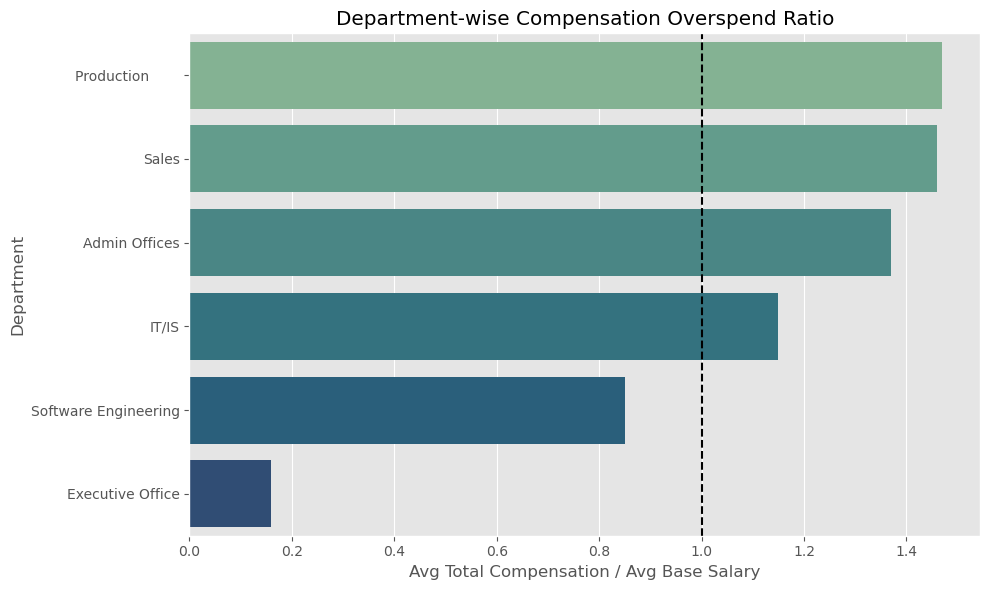

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=dept_spend,
    x='overspend_ratio',
    y='department',
    palette='crest'
)
plt.axvline(1, color='black', linestyle='--')
plt.title('Department-wise Compensation Overspend Ratio')
plt.xlabel('Avg Total Compensation / Avg Base Salary')
plt.ylabel('Department')
plt.tight_layout()
plt.savefig(VISUAL_PATH/'dept_wise_compensation_overspend_ratio.png', dpi=100)
plt.show()

### Interpretation 

This chart compares the average total compensation, which includes salary, overtime, and other pay components, to the average base salary for each department. The vertical dashed line at 1.0 represents the break-even point where employees receive only their base pay without additional overhead.
<br>
<br>
Departments such as Production and Sales show overspend ratios above 1.4, indicating that these areas pay around forty percent more than the base salary. This could be driven by high overtime workloads, variable commissions, or incentive-based pay structures. Admin Offices and IT/IS also show moderate overspending between 1.1 and 1.3, suggesting either operational intensity or additional allowances for extended work hours.
<br>
<br>
Software Engineering sits slightly below parity, implying efficient pay management or fewer overtime incentives. The Executive Office has a very low ratio, consistent with fixed-pay leadership roles that rarely depend on variable compensation.
<br>
<br>
Overall, this visualization reveals that operational departments tend to spend more beyond their salary budgets, while technical and executive units maintain tighter control over compensation variability.

### Section 3 – Yearly Departmental Spend Trends

In [8]:
# Aggregate yearly spend per department
yearly_spend = (
    merged_df.groupby(['year', 'department'])
    .agg(
        avg_salary=('salary', 'mean'),
        avg_total_comp=('total_compensation', 'mean'),
        total_comp_sum=('total_compensation', 'sum'),
        employee_count=('empid', 'nunique')
    )
    .reset_index()
)

# Compute year-over-year growth for total compensation
yearly_spend['yoy_growth'] = (
    yearly_spend.groupby('department')['total_comp_sum']
    .pct_change()
    .round(3)
)

print("Year over year growth for total compensation")
display(yearly_spend.head(10))

Year over year growth for total compensation


,year,department,avg_salary,avg_total_comp,total_comp_sum,employee_count,yoy_growth
0,"2,013.00",Admin Offices,"55,000.00","111,974.15","111,974.15",1,NaN
1,"2,013.00",IT/IS,"95,627.92","112,645.15","1,351,741.76",12,NaN
2,"2,013.00",Production,"59,471.58","98,671.99","4,440,239.76",45,NaN
3,"2,013.00",Sales,"65,609.75","143,412.68","573,650.72",4,NaN
4,"2,013.00",Software Engineering,"90,745.50","34,736.01","138,944.05",4,NaN
5,"2,014.00",Admin Offices,"93,046.00","59,068.00","59,068.00",1,-0.47
6,"2,014.00",IT/IS,"102,442.10","127,080.56","1,270,805.59",10,-0.06
7,"2,014.00",Production,"60,706.11","95,861.24","5,080,645.70",53,0.14
8,"2,014.00",Sales,"65,594.75","127,367.33","1,018,938.66",8,0.78
9,"2,014.00",Software Engineering,"96,355.00","52,243.86","156,731.58",3,0.13


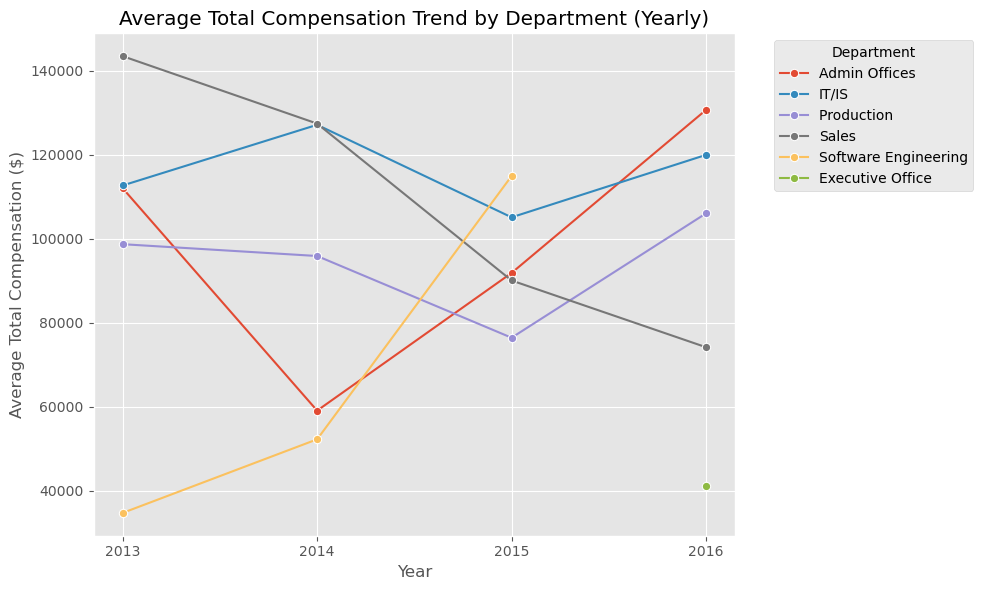

In [9]:
# Trend Lines by Department

plt.figure(figsize=(10,6))
sns.lineplot(
    data=yearly_spend,
    x='year',
    y='avg_total_comp',
    hue='department',
    marker='o'
)
plt.title('Average Total Compensation Trend by Department (Yearly)')
plt.xlabel('Year')
plt.ylabel('Average Total Compensation ($)')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig(VISUAL_PATH/'average_total_compensation_trend_by_department.png', dpi=100)
plt.show()

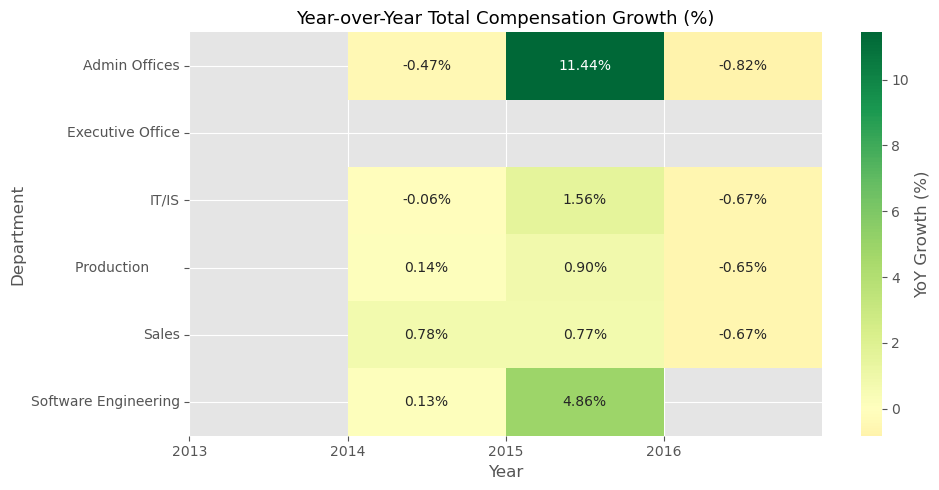

In [10]:
# YoY Growth Heatmap

pivot_growth = yearly_spend.pivot(index='department', columns='year', values='yoy_growth')
pivot_growth.columns = pivot_growth.columns.astype(int)

plt.figure(figsize=(10,5))
ax = sns.heatmap(
    pivot_growth,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'YoY Growth (%)'}
)

for text in ax.texts:
    text.set_text(f"{float(text.get_text()):.2f}%")

plt.title('Year-over-Year Total Compensation Growth (%)', fontsize=13)
plt.xlabel('Year')
plt.ylabel('Department')

plt.xticks(
    ticks=range(len(pivot_growth.columns)),
    labels=pivot_growth.columns.astype(int),
    rotation=0
)

plt.tight_layout()
plt.savefig(VISUAL_PATH / 'year_over_year_total_compensation_growth.png', dpi=100)
plt.show()

### Interpretation

The line plot highlights how average total compensation has evolved from 2013 to 2016 across different departments. Admin Offices and Production show noticeable fluctuations, suggesting variable overtime or bonus components influencing total pay. Sales and IT/IS departments maintain a relatively stable trajectory, while Software Engineering shows a gradual upward climb, reflecting consistent salary adjustments or new role additions. The Executive Office, by contrast, experiences a downward trend that may indicate restructuring or fixed-salary stability.
<br>
<br>
The accompanying heatmap provides a clearer year-over-year comparison of compensation growth rates. Positive values in green represent salary expansion, while negative values in yellow or gray denote a slowdown or contraction. The spike of more than eleven percent in Admin Offices around 2015 is particularly striking, suggesting a policy change, major hiring event, or retention-based pay increase during that period.
<br>
<br>
Together, these visualizations help identify departments with volatile or predictable pay structures. Consistent positive growth reflects sustainable workforce investment, whereas sharp fluctuations may require further review to ensure alignment with long-term compensation policies.